In [94]:
#Import Relevant Packages
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.stats import mannwhitneyu

In [95]:
#load in file
ASD_T5_csv = pd.read_csv('SVDT5_DATA.csv')

ASD_numeric =  ASD_T5_csv


#sort based on diagnosis
ASD_numeric['ados2_4_class'] = ASD_numeric['ados2_4_class'].str.lower()
ASD_numeric = ASD_numeric.sort_values('ados2_4_class', ascending=True )

#ASD_numeric.rename(columns = {"ados2_4_class":"diagnosis"}, inplace = True)



#drop labels
ASD_numeric = ASD_numeric.drop(['study_id'], axis= 1)
#drop all ados
col2drop = [col for col in ASD_numeric.columns if 'ados' in col]

ASD_No_ADOS = ASD_numeric.drop(columns=col2drop)


#transpose data
ASD_No_ADOS = ASD_No_ADOS.transpose()

#remove null participants
ASD_No_ADOS = ASD_No_ADOS.dropna(axis = 1)

#print(ASD_No_ADOS)
###Note: In this organization, the first 38 columns have an ASD diagnosis, and the next 52 do not###

#Lets create a diagnosis List
ASD_Labels = ["ASD"] * 38 + ["Non-spectrum"] * 52

#now, lets finish this up by droping the diagnosis
#ASD_No_ADOS= ASD_No_ADOS.drop(['diagnosis'], axis= 0)

print(ASD_No_ADOS)
print(ASD_Labels)

                                    60     44    36     73     38    106  \
mmse_total_mmse                   29.00  27.00  29.0  30.00  27.00  25.0   
mini_mental_status_exam_complete   2.00   2.00   2.0   2.00   2.00   0.0   
wais_3_pc_raw                     21.00  15.00  24.0  22.00  19.00  20.0   
wais_3_pc_scaled                  11.00   6.00  15.0  12.00   8.00   9.0   
wais_3_v_raw                      56.00  48.00  58.0  50.00  23.00  40.0   
...                                 ...    ...   ...    ...    ...   ...   
wcst_perclr_ts                    43.00  36.00  54.0  49.00  37.00  43.0   
wcst_cc_r                          6.00   3.00   6.0   6.00   5.00   6.0   
wcst_tcc_r                        27.00  24.00  18.0  16.00  13.00  29.0   
wcst_fm_r                          1.00   2.00   1.0   0.00   1.00   1.0   
wcst_ll_r                          0.93  10.61   0.0   2.92  -3.75   7.7   

                                    105    53    77     61   ...    47    48   \
mmse_t

In [96]:
#lets normalize all of our data row by row
def normalize_row(row):
    min_val = row.min()
    max_val = row.max()
    return (row - min_val) / (max_val - min_val)

In [97]:
#normalize and check data

normalized_df = ASD_No_ADOS.apply(normalize_row, axis =1)

print(normalized_df)

                                       60        44        36        73   \
mmse_total_mmse                   0.875000  0.625000  0.875000  1.000000   
mini_mental_status_exam_complete  1.000000  1.000000  1.000000  1.000000   
wais_3_pc_raw                     0.636364  0.090909  0.909091  0.727273   
wais_3_pc_scaled                  0.461538  0.076923  0.769231  0.538462   
wais_3_v_raw                      0.846154  0.692308  0.884615  0.730769   
...                                    ...       ...       ...       ...   
wcst_perclr_ts                    0.415094  0.283019  0.622642  0.528302   
wcst_cc_r                         1.000000  0.500000  1.000000  1.000000   
wcst_tcc_r                        0.142857  0.117647  0.067227  0.050420   
wcst_fm_r                         0.200000  0.400000  0.200000  0.000000   
wcst_ll_r                         0.728927  1.000000  0.702884  0.784654   

                                       38        106       105       53   \
mmse_total_

True
False
Matrix one has the shape (99, 90)


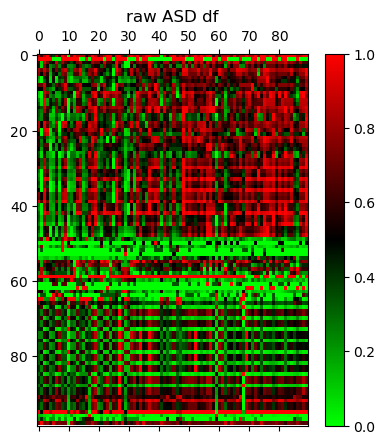

In [98]:
#check data shape
print(normalized_df.isna().values.any())

normalized_df = normalized_df.dropna(axis=0)

print(normalized_df.isna().values.any())

#normalized_df.to_csv("Normalized_DF.csv")

print('Matrix one has the shape ' + str(normalized_df.shape))

#make my colormap
cmap_colors = [(0, 1, 0), (0, 0, 0), (1, 0, 0)]  # Green, Black, Red

# Create a colormap with a gradient using LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors, N=256)

#visualize with positive pixels fazing red, negative fazing green. On scale of 1 to -1
plt.matshow(normalized_df, cmap = custom_cmap)
plt.axis('tight')
plt.colorbar()
plt.title('raw ASD df')
plt.show()




In [99]:
#Discover the Rank
#take an svd and print the length of sigma. 
#This length will be 30 based on number of columns in the matrix
#Then, loop through the sigma array and count number of relevant weights -- i.e. non-zero values.
#This will identify rank. Given how I created the combined pattern, rank will end up as 3. But will calculate regardless



u, sigma, vt = np.linalg.svd(ASD_No_ADOS, full_matrices= False)

#check unbound sigma is 30
print('unbound sigma is length ' + str(len(sigma)))


rank = 0

for num in sigma:
    if num >.01:   ###this is any sigma that is relevant###
        rank = rank + 1
    else:
        rank = rank

#print the total relevant rank.
print('the rank is ' + str(rank))

unbound sigma is length 90
the rank is 90


In [100]:
#now do the SVD with the defined rank using scikit-learn.

from sklearn.utils.extmath import randomized_svd

U, S, VT = randomized_svd(normalized_df, rank)



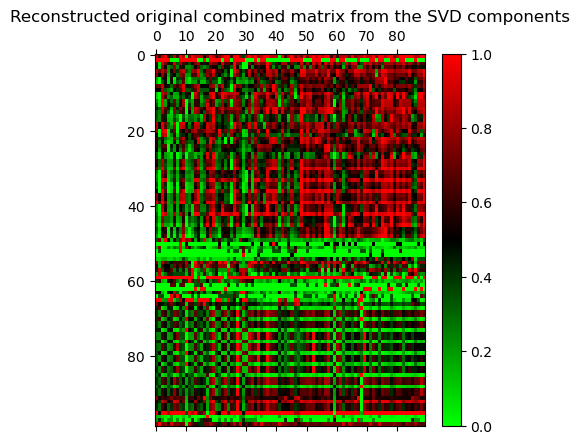

The maximum absolute difference between any two corresponding matrix values is 1.3211653993039363e-14.
The original matrix was successfully reconstructed


In [101]:
#reconstruct the combined matrix to verify the SVD components are correct. Recombining from SVD with rank 3

#make first term of sigma 0 
#S[0] = 0

reconstructed_data = U @ np.diag(S) @ VT
plt.matshow(reconstructed_data, cmap = custom_cmap)
plt.axis('tight')
plt.title('Reconstructed original combined matrix from the SVD components')
plt.colorbar()
plt.show()

#numerically check the recombined matrix. Checking with SVD rank 3
#what is maximum difference between any two correcponding values
numerical_check = np.max(abs(normalized_df- reconstructed_data))
print('The maximum absolute difference between any two corresponding matrix values is ' + str(numerical_check) + '.' )
print('The original matrix was successfully reconstructed')

In [102]:
#Output the components shapes as well as initial matrix shape. 
#U will have rows of original matrix and columns of rank
#sigma should be an array equal to length of rank
#VT will have rows of rank and number of columns of the original matrix
print('The original matrix has shape ' + str(normalized_df.shape))
print('U is of shape ' + str(U.shape))
print('There are ' + str(len(S)) + ' sigma components in the list')
print('V transpose is of the shape ' + str(VT.shape))

U_df = pd.DataFrame(U)
#U_df.to_csv("U.csv")
VT_df = pd.DataFrame(VT)
#VT_df.to_csv("VT.csv")


print('Considering a full rank, everything is the right size!')

The original matrix has shape (99, 90)
U is of shape (99, 90)
There are 90 sigma components in the list
V transpose is of the shape (90, 90)
Considering a full rank, everything is the right size!


Sigma Printed as a diagonal
[[5.09581829e+01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.93648583e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.86529054e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.03153111e-03
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.91836285e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.80495839e-04]]


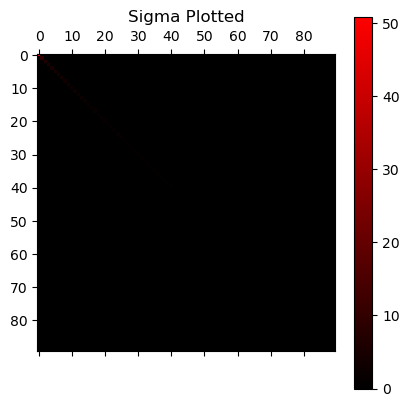

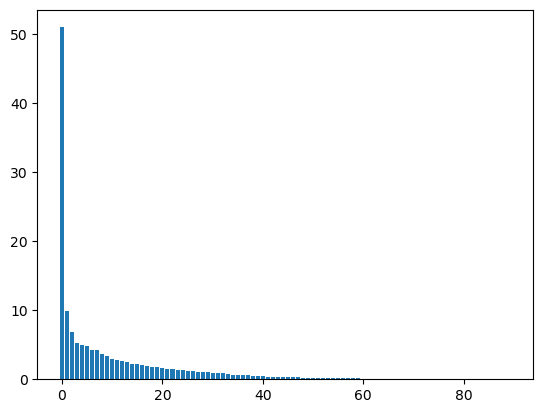

Sigma is Decreasing
Sigma is Decreasing
Sigma is Diagonal. Has Decreasing Values. All Values are Non-Negative


In [103]:
#Print Sigma
print('Sigma Printed as a diagonal')
print(np.diag(S))

cmap_colors_diag = [(0, 0, 0), (1, 0, 0)]  # Black, Red

custom_cmap_diag = LinearSegmentedColormap.from_list("custom_cmap_diag", cmap_colors_diag, N=256)

#Plot Sigma as a Diagonal
plt.matshow(np.diag(S), cmap = custom_cmap_diag)
plt.colorbar()
plt.title('Sigma Plotted')
plt.show()

#sigma as a bar chart
plt.bar(np.arange(len(S)), S)
plt.show()

#make sure sigma is decreasing
for num in np.arange(0,2):
    if S[num] > S[num+1]:
        print('Sigma is Decreasing')
    else:
        print('Uh Oh. Sigma is not decreasing') 

#make sure sigma is non-negative. Check the minimum
#print('minimum of rank 3 sigma is ' + str(np.min(S)) + ' which is greater than 0.')

print('Sigma is Diagonal. Has Decreasing Values. All Values are Non-Negative')

U is column-wise ortho-normal with maximum absolute difference between identity matrix and U self-dot is 2.7755575615628914e-15


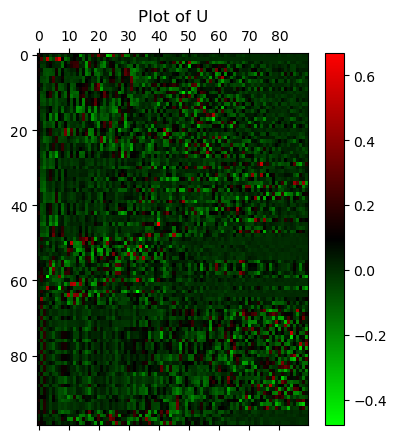

In [104]:
#Way to see U is COLUMN WISEortho-normal, especially with a ton of column in a larger rank
#this will output an identity matrix
#the identity matrix will be of identity rank
UON_check = np.dot(np.transpose(U), U)
UON_ident= np.identity(rank)

print('U is column-wise ortho-normal with maximum absolute difference between identity matrix and U self-dot is ' + str(np.max(np.abs(UON_check-UON_ident))))

#plot U
plt.matshow(U, cmap = custom_cmap)
plt.axis('tight')
plt.colorbar()
plt.title('Plot of U')
plt.show()


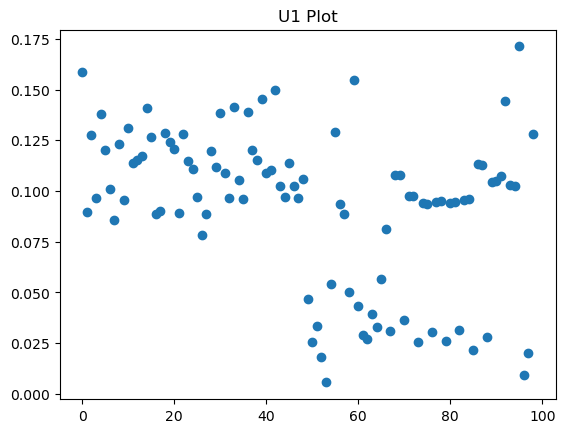

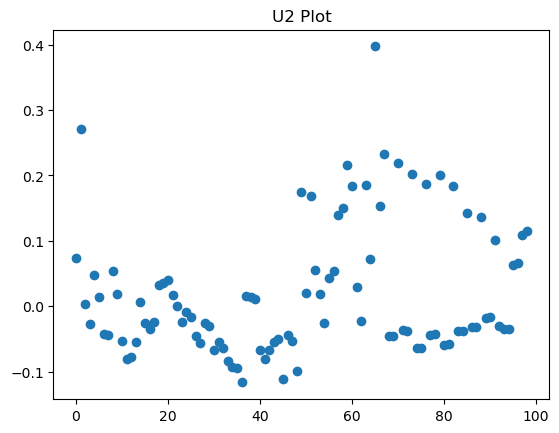

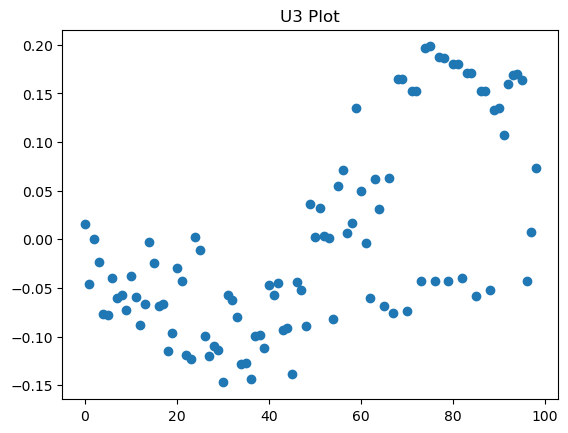

In [105]:
U1 = U[:,0]
U2 = U[:,1]
U3 = U[:,2]
#U4 = U[:,3]
#U6 = U[:,5]
#U15 = U[:,14]
#U19 = U[:,18]

#plot components of U
xlen = np.arange(0,99)
plt.scatter(xlen,U1)
plt.title('U1 Plot')
plt.show()
plt.scatter(xlen,U2)
plt.title('U2 Plot')
plt.show()
plt.scatter(xlen,U3)
plt.title('U3 Plot')
plt.show()
####

Column 0: p-value = 3.8550397321824017e-07 (Significant)
MMSE vs TRAILS: p-value = 0.004165987074325279
MMSE vs PEGBOARD: p-value = 0.021584805047706254
MMSE vs WCST: p-value = 0.027311575830523134
WAIS vs TRAILS: p-value = 2.1666745530171342e-05
WAIS vs HOOPER: p-value = 0.041988380786831994
WAIS vs PEGBOARD: p-value = 0.001984709547679356
WAIS vs WCST: p-value = 7.358972858526508e-06


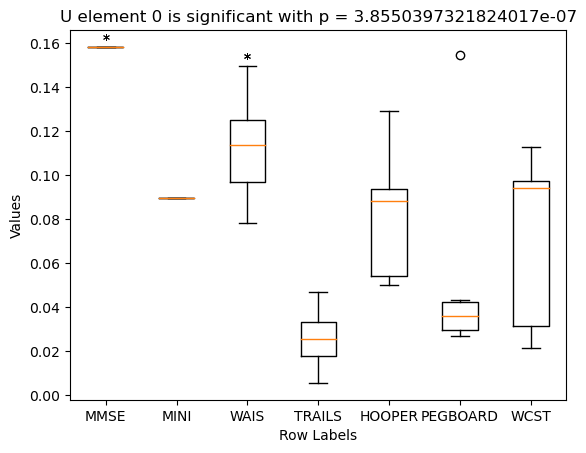

Column 1: p-value = 9.467248584590716e-05 (Significant)
MINI vs WAIS: p-value = 0.035081306995165894
WAIS vs TRAILS: p-value = 0.0031898649397733006
WAIS vs HOOPER: p-value = 0.008300263728885291
WAIS vs PEGBOARD: p-value = 0.0008002773040780148
WAIS vs WCST: p-value = 0.008269504842576283


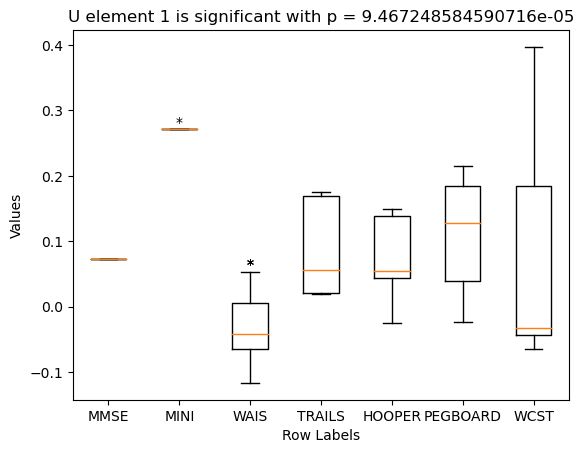

Column 2: p-value = 7.944619399454702e-08 (Significant)
WAIS vs TRAILS: p-value = 0.0034645474873044478
WAIS vs HOOPER: p-value = 0.011858285636771923
WAIS vs PEGBOARD: p-value = 0.0025131820057080487
WAIS vs WCST: p-value = 2.9883478284310997e-09


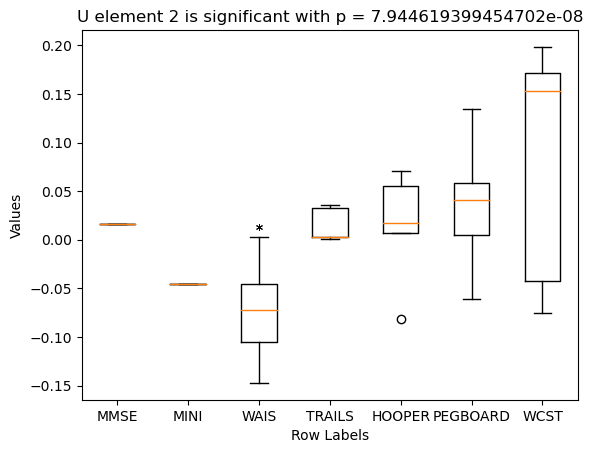

In [119]:
from scikit_posthocs import posthoc_dunn
# List to store significant column indices
significant_columns = []

# Perform Kruskal-Wallis test for each column
for col_idx in range(U.shape[1]):
    # Extract data for the current column
    column_data = [U[row_label, col_idx] for row_label in row_labels.values()]

    # Perform Kruskal-Wallis test
    stat, p_value = kruskal(*column_data)

    # Check if the p-value is less than 0.05
    if p_value < 0.0001:
        significant_columns.append((col_idx,p_value))
        print(f"Column {col_idx}: p-value = {p_value} (Significant)")

        # Perform Dunn's test for pairwise comparisons --  a post hoc analysis
        posthoc_result = posthoc_dunn(column_data)

        # Print pairwise significant differences
        for i, group1 in enumerate(row_labels.keys()):
            for j, group2 in enumerate(row_labels.keys()):
                if i < j:
                    p_val = posthoc_result.iloc[i, j]
                    if p_val < 0.05:
                        print(f"{group1} vs {group2}: p-value = {p_val}")

        # Visualize box plot with significance annotations
        plt.boxplot(column_data, labels=row_labels.keys())
        plt.title(f'U element {col_idx} is significant with p = {p_value}')
        plt.xlabel('Row Labels')
        plt.ylabel('Values')

        # Add significance annotations
        for i, group1 in enumerate(row_labels.keys()):
            for j, group2 in enumerate(row_labels.keys()):
                if i < j:
                    p_val = posthoc_result.iloc[i, j]
                    if p_val < 0.05:
                        plt.annotate('*', xy=(i + 1, max(column_data[i])), ha='center', va='bottom')

        plt.show()


VT is row-wise ortho-normal with maximum absolute difference between identity matrix and VT self-dot is 2.4424906541753444e-15


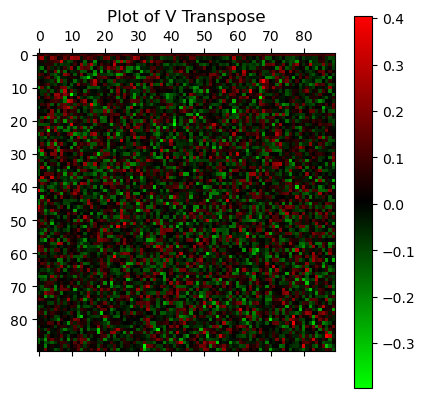

In [107]:
#See VT is ROW WISE ortho-normal
#this will output an identity matrix
#identity of matrix will be of size rank
VTON_check = np.dot(VT,np.transpose(VT))
VTON_ident= np.identity(rank)

print('VT is row-wise ortho-normal with maximum absolute difference between identity matrix and VT self-dot is ' + str(np.max(np.abs(VTON_check-VTON_ident))))


#plot v transpose
plt.matshow(VT, cmap = custom_cmap)
plt.title('Plot of V Transpose')
plt.colorbar()
plt.show()


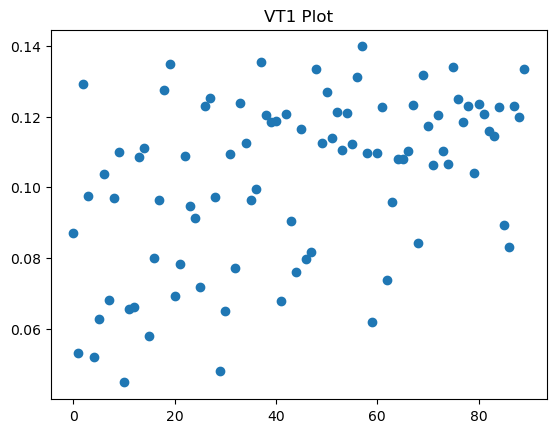

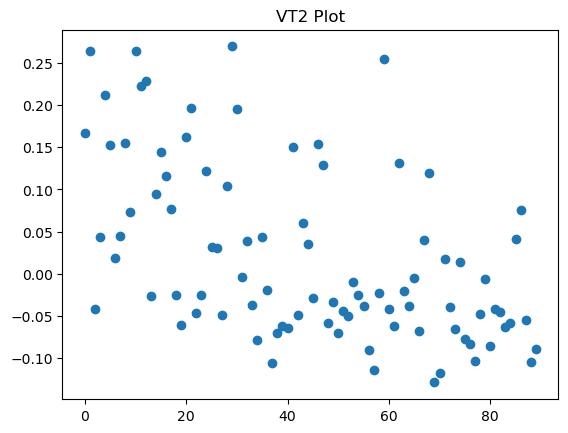

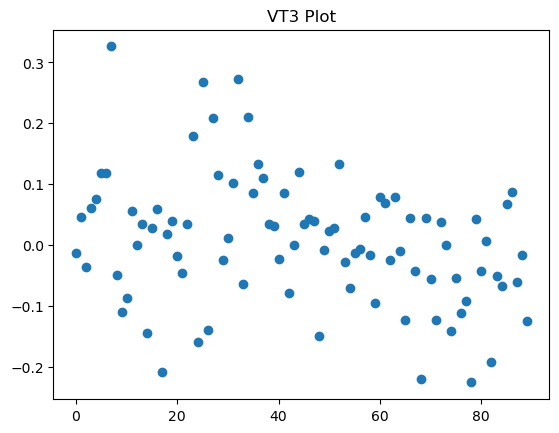

In [108]:
#Plot Components of VT
xlen2 = np.arange(0,90)

VT1 = VT[0,:]
VT2 = VT[1, :]
VT3 = VT[2, :]
#VT4 = VT[3, :]
#VT6 = VT[6, :]
#VT15 = VT[15, : ]
#VT19 = VT[19, : ]

plt.scatter(xlen2,VT1)
plt.title('VT1 Plot')
plt.show()

plt.scatter(xlen2,VT2)
plt.title('VT2 Plot')
plt.show()

plt.scatter(xlen2,VT3)
plt.title('VT3 Plot')
plt.show()




In [109]:
#Start discovering if things are significant
#Use ther wilcoxin test between ASD diagnoses and not-- will create a box plot as well for each V-transpose. 
#then, we can find V-transposes that are significant, and compare them to U. 


#initialize the significant rows

significant_VT = []

#loopthrough each row with a mann-whitney-wilcoxin test

for row_index in range(VT.shape[0]):
    row = VT[row_index]
    
    ASD = row[:38]
    HC = row[38:]

    #perform test
    _, p_value = mannwhitneyu(ASD, HC, alternative= "two-sided")

    #check if p less than .05
    if p_value < 0.05:
        significant_VT.append((row_index, p_value))

#print out relevant rows and P-values

for row_index, p_value in significant_VT:
    print(f"Row {row_index}: p-value = {p_value}")



Row 0: p-value = 0.0004937227172306419
Row 1: p-value = 5.680143442252747e-06
Row 2: p-value = 0.01200452680000931
Row 3: p-value = 0.018842701928718154
Row 5: p-value = 0.0054092842415285345
Row 14: p-value = 0.0036827514109345027
Row 18: p-value = 0.04758936858140635


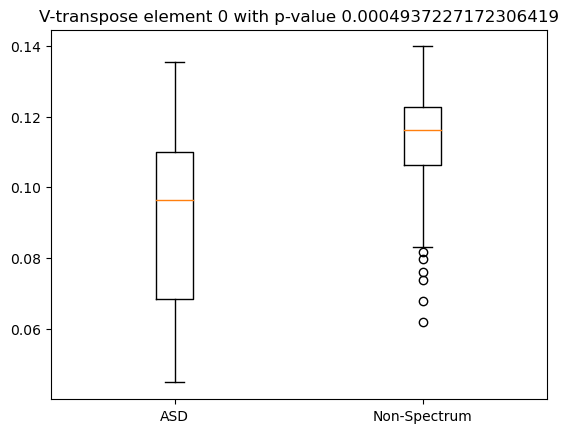

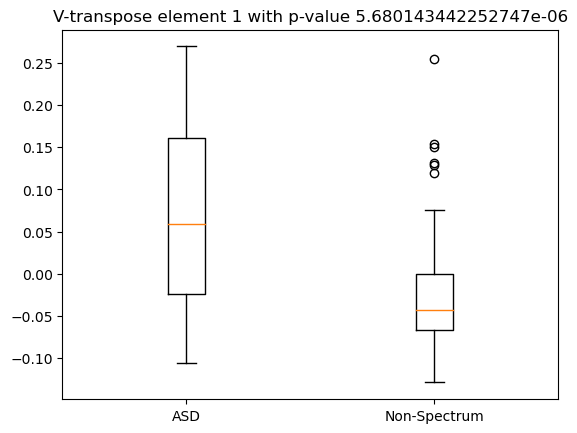

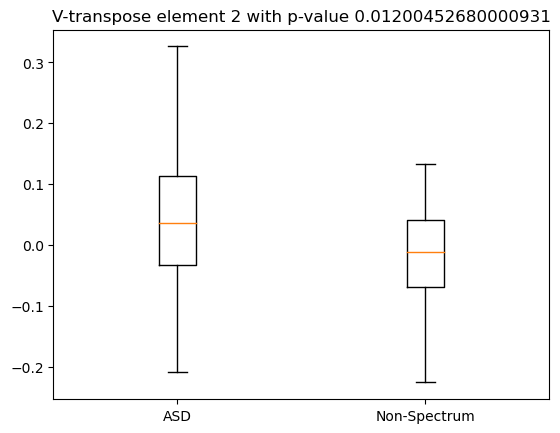

In [110]:
#lets visualize all of this

for row_index, p_value in significant_VT[:3]:
    row = VT[row_index]
    ASD = row[:38]
    HC = row[38:]

    plt.boxplot([ASD,HC], labels = ['ASD','Non-Spectrum'])
    plt.title(f'V-transpose element {row_index} with p-value {p_value}')
    plt.show()

In [121]:
#so, the VT and the U significant labels are ligned up for the first two elements, U 0, 1 and 2 and VT for  0, 1 and 2. 

'''
Lets focus on describing U1 and VT1. So, VT1 shows us that neurotypical (non-spectrum) individuals have a greater 
likelihood or contribute more to the pattern of scoring on cognitive tests in U1 compared to Autistic individuals. 
The scoring patern in U1 has some interesting traits. It reveals relatively high scores on both the MMSE and WAIS scales
Which are more in tune with general executive function and working memory. Then, U1 also shows that neuro-typical 
individuals also score lower on Trails and WCST, which are both cognitive interference oriented task that require 
changing mental paradigms, or mental flexibility. In these scales, low scores are actually a POSITIVE. So, 
overall VT1 and U1 give a pattern of neurotypical people scoring higher in general executive function and having 
greater coignitive flexibility compared to some, but not all individuals on the spectrum. I say some but not all 
due to the incredibly large varience of the ASD label in autism.
'''


'''
Now lets lo0ok at VT2 and U2. VT2 shows ASD population more following pattern U2 compared to the non-ASD population, 
and again note the varience in the ASD label. Now, the patterns in U2 are quite different. first off, the WAIS scores are 
lower, indicating lower executive function scores. Relative to the WAIS, the Trails and WCST scores are higher, implying worse
performance on cognitive flexibility learning tasks. These patterns fit more closely with what we know about ASD, which involves cognitive deficits and
difficulty with cognitive flexibility.
'''


'''
Lastly, I want to touch on the HOOPER and Pegboard tasks. They vary significantly with the WAIS in both U1 and U2. But, they never vary from
eachother. In this sense, you can observe that the items changing are really driven by the WAIS, Trails, and WCST. This actually makes sense. 
Hooper and Pegboard tasks are more measures of motor function. While some cases of more severe ASD have motor deficits, high functioning ASD, 
examined in this sample, is much less likely to show motor deficits in their disability presentation. Thus, these trends imply that executive 
function and cognitive flexibility tasks, not general motor tasks, may be more useful neuropsychological tools to help differentiate ASD and 
neurotypical individuals.
'''





'\nLastly, I want to touch on the HOOPER and Pegboard tasks. They vary significantly with the WAIS in both U1 and U2. But, they never vary from\neachother. In this sense, you can observe that the items changing are really driven by the WAIS, Trails, and WCST. This actually makes sense. \nHooper and Pegboard tasks are more measures of motor function. While some cases of more severe ASD have motor deficits, high functioning ASD, \nexamined in this sample, is much less likely to show motor deficits in their disability presentation. Thus, these trends imply that executive \nfunction and cognitive flexibility tasks, not general motor tasks, may be more useful neuropsychological tools to help differentiate ASD and \nneurotypical individuals.\n'

In [ ]:
#Laastly, lets do some hypergeometric p-values on the ASD VT1 and VT2 as a way to look at significance, and greater account for varience. 

